가설/문제   
- 클러스터 라벨링을 기준으로 유저 분류하기
- 라이트 유저(중립유저/무,소과금 유저)와 헤비유저의 이탈 예측 및 요인 분석

# 1. Loading data

In [1]:
### Library ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import plot_partial_dependence, partial_dependence
# from pdpbox.pdp import pdp_isolate, pdp_plot

### config ###
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
random_states = 42

In [2]:
### Loading data(train) ###
activity = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_activity.csv')
combat = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_combat.csv')
label = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_label.csv')
payment = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_payment.csv')
pledge = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_pledge.csv')
trade = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_trade.csv')

# ### Loading data(test) ###
# activity_test = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\test1_activity.csv')
# combat_test = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\test1_combat.csv')
# payment_test = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\test1_payment.csv')
# pledge_test = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\test1_pledge.csv')
# trade_test = pd.read_csv(r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\test1_trade.csv')

### 1.1 Data checking

In [3]:
# print(activity.shape)
# activity.head()

In [4]:
# combat.head()

In [5]:
# label.head()

In [6]:
# print(payment.shape)
# payment.head()

In [7]:
# print(pledge.shape)
# pledge.head()

In [8]:
# trade.head()

## 1.1 데이터 집계 하기 
activity -> account로 집계
trade -> 거래 빈도만 추출 (source_char_id 와 target_char_id로 count)   
pledge -> 혈맹 활성화 정도 피쳐 생성 combat_char_cnt / play_char_cnt   
combat -> 병합 후 직업/레벨 드랍   

### account 기준으로 데이터 집계하기 (day, activity 기준 집계)
시계열 데이터를 다룰 것이므로 day도 집계 기준에 포함한다..

In [9]:
# 필요없는 컬럼 제거
# activity.drop('server', axis = 1, inplace = True)
# combat.drop('server', axis = 1, inplace = True)

**Activity, Combat**

In [10]:
# # 총 account 개수 확인 (day에 상관없이)
# total_acc = activity.groupby('acc_id').sum().shape[0]

# # activity
# activity_agg = activity.groupby(['day','acc_id'], as_index = False).sum()
# acc_per_day = activity_agg.groupby('day').count()['acc_id']

# # print('관찰 기간 총 유저 수 : ',total_acc)
# # print('일 별 접속 account 수 : \n', acc_per_day)

# # combat
# combat_agg = combat.groupby(['day','acc_id'], as_index = False).sum().drop(['char_id','class','level'], axis = 1)

**pledge**   
혈맹 데이터는 속한 그룹의 데이터라 전부다 쓰기에는 캐릭터별 혈맹이 다 다른 경우 데이터가 잘못 해석될 여지가 있다. 따라서 캐릭터 별 해당 혈맹의 활성화 정도를 나타내는 피쳐를 생성한 후 이 값을 account와 day로 집계한다.   
혈맹 활성화 정도(pledge_activated_rate) = 전투에 참여한 혈맹원 수 / 게임에 접속한 혈맹원 수   
전쟁게임으로 혈맹 구성원들이 얼마나 전투에 참여하는지를 활성화 정도로 정의한다.

In [11]:
# # pledge 피쳐 엔지니어링
# pledge['pledge_activated_rate'] = pledge['combat_char_cnt'] / pledge['play_char_cnt']  
# pledge_agg = pledge.groupby(['day','acc_id'], as_index = False).mean()[['day','acc_id','pledge_activated_rate']]# 혈맹 데이터는 활성화 정도만 볼 것이므로 mean으로 집계

# pledge_agg

**Trade**   
거래 account 별 거래 빈도를 구한다.

In [12]:
# # 판매 유저 기준 거래빈도 집계 
# trade_sell_agg = trade.groupby(['day','source_acc_id'], as_index = False).count()[['day','source_acc_id','time']]
# trade_sell_agg = trade_sell_agg.rename({'source_acc_id':'acc_id','time':'freq_selling'}, axis= 1)

# # 구매 유저 기준 거래빈도 집계
# trade_buy_agg = trade.groupby(['day','target_acc_id'], as_index = False).count()[['day','target_acc_id','time']]
# trade_buy_agg = trade_buy_agg.rename({'target_acc_id':'acc_id','time':'freq_buying'}, axis= 1)

# # 구매, 판매 데이터 합치기
# trade_agg = pd.concat([trade_sell_agg, trade_buy_agg])

**Payment**   
따로 없음

## 1.2 데이터 병합 하기(전처리) 
분석 및 학습 편의성을 위해 위의 데이터셋을 한 데이터셋으로 병합한다. 
- play 타임이 있는 activity 데이터 기준으로 left join
- 데이터 셋 기준은 케릭터가 아닌 유저 account 기준

In [13]:
## 데이터 전처리 함수화
def merger(activity, combat, pledge, trade, payment):
        
    # 필요없는 컬럼 제거
    activity.drop('server', axis = 1, inplace = True)
    combat.drop(['server', 'char_id','class','level'], axis = 1, inplace = True)

    # Aggregating 
    activity_agg = activity.groupby(['day','acc_id'], as_index = False).sum()
    combat_agg = combat.groupby(['day','acc_id'], as_index = False).sum()

    # pledge 피쳐 엔지니어링
    pledge['pledge_activated_rate'] = pledge['combat_char_cnt'] / pledge['play_char_cnt']  
    pledge_agg = pledge.groupby(['day','acc_id'], as_index = False).mean()[['day','acc_id','pledge_activated_rate']]# 혈맹 데이터는 활성화 정도만 볼 것이므로 mean으로 집계

    ## Trade agg ##
    # 판매 유저 기준 거래빈도 집계 
    trade_sell_agg = trade.groupby(['day','source_acc_id'], as_index = False).count()[['day','source_acc_id','time']]
    trade_sell_agg = trade_sell_agg.rename({'source_acc_id':'acc_id','time':'freq_selling'}, axis= 1)

    # 구매 유저 기준 거래빈도 집계
    trade_buy_agg = trade.groupby(['day','target_acc_id'], as_index = False).count()[['day','target_acc_id','time']]
    trade_buy_agg = trade_buy_agg.rename({'target_acc_id':'acc_id','time':'freq_buying'}, axis= 1)

    # 구매, 판매 데이터 합치기
    trade_agg = pd.concat([trade_sell_agg, trade_buy_agg])

    ##### 데이터 병합 #####
    df_merge = activity_agg.drop('char_id', axis = 1).copy()

    for dataset in [combat_agg, pledge_agg, payment, trade_agg]: #combat_agg, pledge_agg, payment, trade_agg
        df_merge = df_merge.merge(right = dataset, how = 'left', on = ['day','acc_id'])

    return df_merge

df_merge = merger(activity, combat, pledge, trade, payment)
# X_test = merger(activity_test, combat_test, pledge_test, trade_test, payment_test)

# 2. EDA

### 2.0 일별 접속자 확인하기
- 유저들 한 계정당 평균 40개의 캐릭터를 가지고 있다.    
-> 현실적으로 사람이 모든 캐릭터를 골고루 들어가서 다양한 플레이 패턴을 보이는 것은 힘들기에, 한 계정 별 각 캐릭터가 다른 행동패턴을 보인다는 가정이 아닌,   
계정 당 캐릭터들 행동 값의 합이 그 계정의 플레이 패턴을 보여준다고 가정. (즉, 캐릭터 별 행동패턴 특성은 무시한다.)   
- 일별 접속자 수는 증가하는 양상을 보인다. 즉, 이 데이터에는 중간에 유저가 합류할 수도 있다는 의미.

### (번외) label 데이터로 현질유저 살펴보기
- 관찰 기간(64일) 동안 현질을 한 번도 안한 유저는 41% (account 기준)   
- 하지만 이는 '관찰 기간' 내 현질을 안한 유저이므로 이것으로 현질을 전혀 안하는 유저라고 판단하기는 힘들다.   
- '라이트 유저'를 정의하기 위해서는 좀 더 많이 들어다 보아야 한다.
- 현질 유저를 나눌 필요가 없다.

In [14]:
# 일별 접속자 수
users_per_day = activity.groupby('day').count()['acc_id']
# users_per_day

현질 X : 16438 
현질 O : 23562


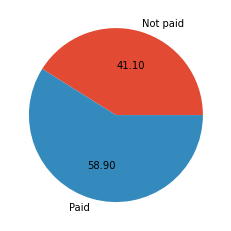

In [15]:
# 현질유저는 몇 명?
no_cash = label.query('amount_spent == 0')['amount_spent'].count()
love_cash = label.query('amount_spent != 0')['amount_spent'].count()

print('현질 X :',no_cash,'\n현질 O :', love_cash)
plt.pie([no_cash, love_cash], labels=['Not paid','Paid'], autopct= '%.2f');

(40000, 3)


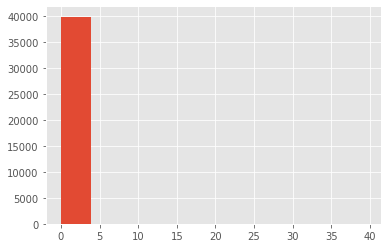

In [16]:
print(label.shape)
plt.hist(label['amount_spent']);

### 2.1 결측치/중복값 확인하기
- join 할 때 외부 데이터에서 일정 결측값 존재하나, 해당 외부데이터에 값이 없는 경우는 그냥 이력이 없는 것으로 추후 결측치 처리시 0 으로 대채한다.
- key 값을 제외한 모든 값이 numeric data
- 중복값은 없다.

In [17]:
# 데이터 타입 및 결측값 확인
df_merge.info()

df_merge[df_merge.duplicated( keep = False)] # 중복값 없음

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1111906 entries, 0 to 1111905
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   day                    1111906 non-null  int64  
 1   acc_id                 1111906 non-null  int64  
 2   playtime               1111906 non-null  float64
 3   npc_kill               1111906 non-null  float64
 4   solo_exp               1111906 non-null  float64
 5   party_exp              1111906 non-null  float64
 6   quest_exp              1111906 non-null  float64
 7   rich_monster           1111906 non-null  int64  
 8   death                  1111906 non-null  float64
 9   revive                 1111906 non-null  float64
 10  exp_recovery           1111906 non-null  float64
 11  fishing                1111906 non-null  float64
 12  private_shop           1111906 non-null  float64
 13  game_money_change      1111906 non-null  float64
 14  enchant_count     

,day,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,...,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,pledge_activated_rate,amount_spent,freq_selling,freq_buying


### 2.2 Numeric data 살펴보기
#### 2.2.1 통계치

In [18]:
# 수치형 변수 대푯값 살펴보기
# df_merge.describe().T

In [19]:
# 분포 리포트
# profile = ProfileReport(df_merge, title = 'profiling', minimal= True)
# profile.to_file("report.html")

### 2.3 상관관계

In [20]:
# plt.figure(figsize = (20,20))
# corr = df_merge.corr()
# sns.heatmap(corr, annot = True); # revive 와 death 는 너무 높은 상관관계. revive drop 하자

상관관계를 살펴보면...
- 플레이타임은 개인상점 운영시간과 강한 상관관계를 갖는다. (그도 그럴 것이 둘다 '시간' 개념이기에...거래 빈도 데이터를 만들었으니 이 컬럼은 드롭한다.)
- 재미있는 점은 개인상점 운영시간과 소속 혈맹의 활성화 정도는 음의 상관관계를 갖는다. 거래용 계정은 혈맹 가입이 없거나 전투를 거의 안하는 혈맹에 가입하는 것일까?
- 혈맹간 전투 참여횟수와 전투 상대 캐릭터 수는 강한 양의 상관관계. 당연하다. 전투에 많이 참여할 수록 전투 상대 캐릭터는 많을 수 밖에. 상관관계가 너무 높으므로 전투 상대 캐릭터 수는 드롭한다.
- 이정도 정리하면 상관관계 문제는 발생안할듯.

In [21]:
# df = df_merge.merge(label, how = 'left', on = 'acc_id')
# df.corr()['survival_time'].sort_values(ascending = False) # 으아ㅏㅏ....상관관계 왜이래

In [22]:
# 이상치 확인
# for col in df.columns:
#     sns.boxplot(x = df[col])
#     plt.show()

# 3. Data wrangling & Feature engineering
### 3.1 필요없는 컬럼 드랍 및 이상치 제거

In [23]:
X = df_merge.copy()
# X_test_processed = X_test.copy()

## 데이터 전처리 함수화
def processor(X, y):
    # 결측치 0으로 반환
    X = X.fillna(0)

    # 새로운 피쳐 생성 (경험치 total)
    X['total_exp'] = X['solo_exp'] + X['party_exp'] + X['quest_exp']

    # 필요없는 컬럼 드랍
    drop_col = ['revive','private_shop','num_opponent','day','fishing','solo_exp','party_exp','quest_exp']
    X.drop(drop_col, axis = 1, inplace = True)

    # 시계열 데이터 처리 - 집계 - 누적
    X = X.groupby('acc_id', as_index = False).sum()
    
    # 집계한 데이터를 라벨과 합치기
    y = y.iloc[:,:-1]
    df = X.merge(y, how = 'left', on = 'acc_id')

    # 집계했던 인덱스 제거
    df.drop(['acc_id'], axis = 1, inplace = True)
    return df

df = processor(X, label)

In [24]:
# 결측치 확인
print('결측치', df.isna().sum().sum()) # , X_test.isna().sum().sum()

결측치 0


In [25]:
# # IQR 기준으로 이상치 제거하기 (작업장일 수도)
# def remove_out(X_train, cols):
#     for col in cols:
#         level_1q = X_train[col].quantile(0.25)
#         level_3q = X_train[col].quantile(0.75)
#         IQR = level_3q - level_1q
#         rev_range = 3  # 제거 범위 조절 변수
#         dff = X_train[col][(X_train[col] <= level_3q + (rev_range * IQR)) & (X_train[col] >= level_1q - (rev_range * IQR))]
#         dff = dff.reset_index(drop=True)

#     return dff

# cols = X_train.columns[1:]
# remove_out(X_train, cols)

In [26]:

#acc 기준 집계
# df_merge = df_merge.groupby('acc_id').sum().merge(label)

# 4. 모델링

## 4.1 망했으니까 무지성으로 이탈 유저 예측하기 (모델링)

### 4.1.1 data split

In [27]:
## target 분류 모델 데이터로 변환
target = 'survival_time'
df[target] = df[target].map(lambda x : 0 if x == 64 else 1) # 이탈은 1

X = df.drop(target, axis = 1)
y = df[target]

# train, test 셋 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# baseline 생성
baseline = np.repeat(y_train.mode()[0], len(y_train))
print( X_train.shape, X_test.shape, y_train.shape, y_test.shape, baseline.shape)

(32000, 18) (8000, 18) (32000,) (8000,) (32000,)


### 4.1.2 모델 선택하기

In [28]:
# 여러 모델 기본 설정으로 돌려서 비교하기.
xgb = XGBClassifier(random_state = random_states, n_jobs = -1)
rf = RandomForestClassifier(random_state = random_states, n_jobs = -1)
logi = LogisticRegression(random_state=random_states, n_jobs= -1)

xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)
logi.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

**모델 선택의 기준은 cv score를 기준으로 한다.**   
score : f1 ? roc_auc ? 나는 type1, type2 error 중 무엇이 더 중요한가?   
-> 아 이래서 nc에서 기대 이익을 최대화하는 모델을 만드려 했구나. 맞추는게 중요한게 아니라 맞춰서 나갈 애한테 얼마만큼의 기대 이익이 있고 돈 얼마나 줘야 하는지 생각하니까.   

일단 나만의 지표를 만들기에 시간이 부족하므로 둘 중 최적을 고르자.
이탈예측에서 이탈이라고 판정될 경우 이를 붙잡기 위한 재화가 투입된다. (그게 얼마든) 고래가 나간다고 하면 얼마가 들든 붙잡아야 할 것이다.
안나갈 애들 돈 주기 vs 나갈 애 안붙잡기 :    
nc 게임 특성 상 안나갈 애들 돈주는게 더 치명적. 어짜피 사회적 연결망에 의해 잘 안나갈 확률이 높음.
- FP를 최소화 해야한다.

검증

In [29]:
### 훈련세트에 대한 Roc_auc score
print('xgb :',roc_auc_score(y_train, xgb.predict(X_train)))
print('rf : ',roc_auc_score(y_train, rf.predict(X_train)))
print('logi : ',roc_auc_score(y_train, logi.predict(X_train)))

xgb : 0.826451041799104
rf :  0.9999432237551809
logi :  0.6785575724875521


In [30]:
# baseline 정확도
print('roc_score of baseline: ', roc_auc_score(y_train, baseline))

# cv score - roc
cv_xgb = cross_val_score(
    xgb, 
    X_train, 
    y_train, 
    cv = 5,
    scoring = 'roc_auc'
    )
print('xgb : %0.2f roc'% cv_xgb.mean(),'with std : %0.2f'%cv_xgb.std())

cv_rf = cross_val_score(
    rf, 
    X_train, 
    y_train, 
    cv = 5,
    scoring = 'roc_auc'
    )
print('rf : %0.2f roc'% cv_rf.mean(),'with std : %0.2f'%cv_rf.std())

cv_logi = cross_val_score(
    logi,
    X_train, 
    y_train, 
    cv = 5,
    scoring = 'roc_auc'
    )
print('logi : %0.2f roc'% cv_logi.mean(),'with std : %0.2f'%cv_logi.std())

roc_score of baseline:  0.5
xgb : 0.81 roc with std : 0.00
rf : 0.82 roc with std : 0.00
logi : 0.75 roc with std : 0.00


In [31]:
# 스코어 저장
cv_score = cv_rf.mean()
cv_std = cv_rf.std()

### 4.1.3 선택한 모델 하이퍼 파라미터 튜닝

In [32]:
rf = RandomForestClassifier(
    max_depth = 9,
    # n_estimators = 300,
    # max_samples= 200,
    random_state = random_states, 
    n_jobs= -1
    )

rf.fit(X_train, y_train)

rf_score = roc_auc_score(y_train, rf.predict(X_train))
print('Before AUC:', '%0.2f'%cv_score)
print('파라미터 튜닝 후 : ', rf_score)

Before AUC: 0.82
파라미터 튜닝 후 :  0.7626578399436419


In [33]:
params = {
    'max_depth' : range(6, 30),
    'n_estimators' : [100, 200, 300, 400, 500, 600]
    }

clf = RandomizedSearchCV(
    rf,
    param_distributions= params,
    cv = 3,
    n_iter = 10,
    scoring = 'roc_auc',
    random_state = 42,
    verbose = 3,
    error_score= 'raise'
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ....max_depth=25, n_estimators=400;, score=0.825 total time=  34.3s
[CV 2/3] END ....max_depth=25, n_estimators=400;, score=0.824 total time=  31.2s
[CV 3/3] END ....max_depth=25, n_estimators=400;, score=0.829 total time=  27.3s
[CV 1/3] END .....max_depth=9, n_estimators=200;, score=0.807 total time=   9.3s
[CV 2/3] END .....max_depth=9, n_estimators=200;, score=0.807 total time=   9.6s
[CV 3/3] END .....max_depth=9, n_estimators=200;, score=0.810 total time=   9.4s
[CV 1/3] END ....max_depth=19, n_estimators=500;, score=0.824 total time=  45.2s
[CV 2/3] END ....max_depth=19, n_estimators=500;, score=0.823 total time=  38.6s
[CV 3/3] END ....max_depth=19, n_estimators=500;, score=0.828 total time=  43.4s
[CV 1/3] END ....max_depth=22, n_estimators=200;, score=0.824 total time=  19.2s
[CV 2/3] END ....max_depth=22, n_estimators=200;, score=0.823 total time=  19.5s
[CV 3/3] END ....max_depth=22, n_estimators=200;

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(max_depth=9, n_jobs=-1,
                                                    random_state=42),
                   param_distributions={'max_depth': range(6, 30),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [34]:
print("Optimal Hyperparameter:", clf.best_params_)
print('Before AUC:', '%0.2f'%cv_score)
print("After AUC:", clf.best_score_)

Optimal Hyperparameter: {'n_estimators': 400, 'max_depth': 25}
Before AUC: 0.82
After AUC: 0.8260568633783848


#### 베이지안 서치 해보기

In [35]:
params = {
    'randomforestclassifier__max_depth' : hp.randint('max_depth', 6, 30),
    'randomforestclassifier__n_estimators' : hp.quniform('n_estimators', 100, 600, 50),
    'randomforestclassifier__max_features' : hp.uniform('max_features', 0, 1)
    }

In [36]:
##### 파이프라인 설정 #####
def get_pipe(params):
		
    params["randomforestclassifier__max_depth"] = int(params["randomforestclassifier__max_depth"])  # max_depth는 정수형으로 변환해 줍니다.
    params["randomforestclassifier__n_estimators"] = int(params["randomforestclassifier__n_estimators"])
    ### pipeline ###
    pipe = make_pipeline(
        RandomForestClassifier(
            random_state = random_states, 
            n_jobs= -1 
            )
        )
    pipe = pipe.set_params(**params)  ### 여기 참고하면 파라미터 설정을 편하게 가능
    return pipe

#####학습-검증 함수 작성 #####
def fit_and_eval(params):
    pipe = get_pipe(params) 
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="roc_auc") # 검증함수
    avg_cv_score = np.mean(score)

    return {"loss": -avg_cv_score, "status": STATUS_OK}

trials = (Trials())  
best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=80
)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색

100%|██████████| 80/80 [1:40:18<00:00, 75.23s/trial, best loss: -0.8261314907517674] 


In [37]:
# 결과 확인하기
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 AUC: ", -trials.best_trial["result"]["loss"])

trials.trials 
## 최적 하이퍼파라미터:  {'max_depth': [29], 'max_features': [0.2144243681273849], 'n_estimators': [550.0]}
## 최적 AUC:  0.8261314907517674

최적 하이퍼파라미터:  {'max_depth': [29], 'max_features': [0.2144243681273849], 'n_estimators': [550.0]}
최적 AUC:  0.8261314907517674


[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.8246953711264107, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'max_depth': [0], 'max_features': [0], 'n_estimators': [0]},
   'vals': {'max_depth': [17],
    'max_features': [0.4354639477491601],
    'n_estimators': [550.0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 10, 6, 14, 29, 42, 336000),
  'refresh_time': datetime.datetime(2022, 10, 6, 14, 31, 40, 619000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.8159421887920543, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'max_depth': [1], 'max_features': [1], 'n_estimators': [1]},
   'vals': {'max_depth': [11],
    'max_features': [0.732205758828851],
    'n_estimators': [150.0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': da

In [59]:
pipe = get_pipe(max_depth = 29, max_features = 0.2144243681273849, n_estimators = 550)

TypeError: get_pipe() got an unexpected keyword argument 'max_depth'

In [38]:
# 모델 최종 성능 평가
y_pred = clf.best_estimator_.predict(X_test)

print('검증세트 roc : %.2f'%roc_auc_score(y_test,y_pred))
print('검증세트 정확도 : %.2f'%accuracy_score(y_test,y_pred)) # 이정도면 나쁘지 않아.

검증세트 roc : 0.73
검증세트 정확도 : 0.74


# 5. 모델 해석

## 5.1 feature importance

In [39]:
model = clf.best_estimator_

In [40]:
# 중요도 확인
importance = pd.DataFrame(
    zip(model.feature_names_in_, model.feature_importances_), 
    columns=['feature','importance']
    )

# 상위 5개 높은 중요도
importance.sort_values(by = 'importance', ascending = False).head(5)

,feature,importance
0,playtime,0.157
17,total_exp,0.118
5,game_money_change,0.096
1,npc_kill,0.094
13,pledge_activated_rate,0.072


## 5.2 Permutation importance

In [41]:
model = clf.best_estimator_

def get_permutation_importance(X, y, model):
    permuter = PermutationImportance(
        model, 
        scoring = 'roc_auc', 
        n_iter = 5, 
        random_state = 42
        )
    permuter.fit(X, y)

    return permuter

permuter = get_permutation_importance(X_test, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)

In [42]:
print("Top3 Important Features:")
print(p_i[:5])

Top3 Important Features:
[('playtime', 0.10525451118696905), ('total_exp', 0.062456126672844434), ('npc_kill', 0.036924065893869006), ('pledge_activated_rate', 0.025543553646301297), ('rich_monster', 0.023138731082737184)]


## 5.3 ICE plot

In [43]:
##### ICE plot templete #####
def ICE_ploting(point, feature, X_test, model):
    """
    ### Input ###
    Point : 내가 보고싶은 관측값 (datapoint)
    feature : 영향력을 확인하고싶은 피쳐 (수치형)
    (범위형일 경우는 없음. 왜냐면 전처리 파이프라인에서 ordinal encoding을 했기 때문.
    dummy 변수인 경우는 언젠가 확인하자...)
    X_test : 테스트/검증 데이터 셋
    model : 해석에 사용할 모델
    """
    # Select one datapoint in test/validation set (encoded)
    one_datapoint = X_test.iloc[[point]].copy()

    # 해당 피쳐 범위의 최대 최소
    try:
        feature_range = np.arange(X_test[feature].min(), X_test[feature].max() + 1)
    except:
        print('feature error')

    results = []


    for value in feature_range:
        one_datapoint[feature] = value  # feature값을 바꿈
        one_datapoint_pred_proba = model.predict_proba(one_datapoint)[
            :, 1
        ]  # 모델이 feature 값이 바뀐 데이터로부터 확률을 예측
        results.append(one_datapoint_pred_proba.item())  # 각 확률을 리스트에 담아 둡니다.
    results = np.array(results)
    results -= results[0]  # 나이가 최소일 때 모델 예측 확률로부터의 변화값을 볼 것입니다.

    # ICE Plot 반환
    plt.plot(feature_range, results)
    plt.xlabel(feature)
    plt.ylabel("$\Delta$ pred_proba")
    plt.title(f'ICE Plot for {feature} at datapoint {point}')

    return plt.show()

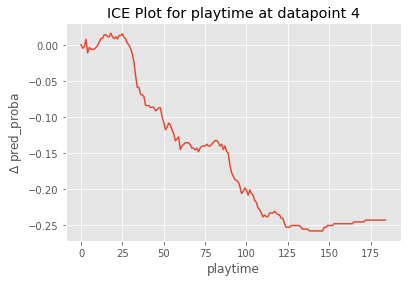

In [44]:
ICE_ploting(4, 'playtime', X_test, model)

## 5.4 PDP plot

c:\Users\jamsu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


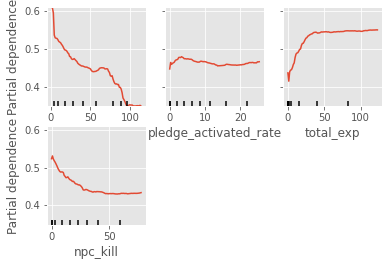

In [45]:
plot_partial_dependence(
    estimator = model,
    X = X_test,
    features = ['playtime', 'pledge_activated_rate','total_exp','npc_kill'], 
    kind = 'average' # ICE plot 같이보고 싶으면 'both'로 설정
    ) # 오래걸림

<AxesSubplot: ylabel='Frequency'>

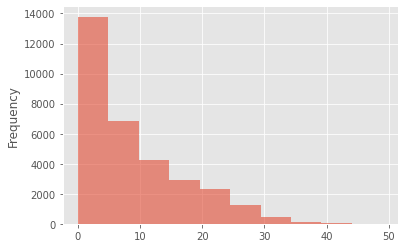

In [46]:
X_train.pledge_activated_rate.plot.hist(alpha = 0.6)

In [47]:
# ## 화질 설정 ##
# plt.rcParams["figure.dpi"] = 144

# ## Pdp
# target_feature = "playtime"

# isolated = pdp_isolate(
#     model=model,
#     dataset=X_test,
#     model_features=X_test.columns,
#     feature=target_feature,
#     grid_type="percentile",  # default = 'percentile', or 'equal'
#     num_grid_points=10,  # default = 10
# )
# pdp_plot(isolated, feature_name=target_feature)

# 5.4 최종 결론
해석한 결과를 보았을 때, 모델 예측에 높은 영향을 주는 feature는 feature importances와 permutation importances의 상위 5개 중 공통적으로 나타나는 항목은 다음과 같다.   
**예측에 영향을 준 상위 feature**  
1. playtime
2. total_exp
3. npc_kill
4. pledge_activated_rate   
   
이에 대하여 종합적으로 해석하자면, 본 예측 모델은...   
**일평균 플레이타임이 높을 수록, 일 평균 경험치 획득량이 적을 수록, 일 평균 npc kill이 많을 수록, 혈맹 활성화 정도가 높을 수록 이탈을 할 확률이 낮다고 예측하는 경향**이 있다. # 해석 보강 필요

# (삽질) 망한 클러스터링

### 3.2 클러스터링 (day 기준)   
고객 분류에 사용할 라벨을 생성하기 위하여 k-means clustering을 사용한다. k 개수 검증은 실루엣 계수를 사용하고 싶었으나... 컴퓨터 자원 부족으로 elbow method를 사용한다...
______________
망했다. 클러스터링 접는다.

In [48]:
# # clustering
# n_clusters = range(2,10)
# sse = {}

# for k in n_clusters:
#     pipe_day = make_pipeline(
#         StandardScaler(),
#         SimpleImputer(strategy='constant', fill_value = 0),
#         KMeans(n_clusters = k, random_state= random_states)
#     )

#     cluster = pipe_day.fit(train)
#     sse[k] = pipe_day['kmeans'].inertia_
    
# # 결과 시각화

# plt.title('The Elbow Method')
# plt.xlabel('Values of k')
# plt.ylabel('SSE')
# sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
# plt.show() # 젠장

In [49]:
# pipe_day = make_pipeline(
#     StandardScaler(),
#     SimpleImputer(strategy='constant', fill_value = 0),
#     KMeans(n_clusters = 3, random_state= random_states)
# )

# cluster = pipe_day.fit(train.loc[:,['playtime','amount_spent']])
# train['cluster'] = cluster['kmeans'].labels_

In [50]:
# train.groupby('cluster', as_index = False).mean().T

In [51]:
# ### scores ###
# print('rf\n', classification_report(y_train, rf.predict(X_train))) 

In [52]:
train_tmp = activity.groupby('char_id').mean()

In [53]:
features = ['day','playtime','npc_kill','solo_exp','party_exp','quest_exp','rich_monster','death','fishing','private_shop','enchant_count']
train_tmp.describe()

,day,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
count,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000
mean,14.881,65472.859,0.459,0.206,0.186,0.075,0.207,0.059,0.043,0.039,0.031,0.080,0.112,-0.001,0.010
std,6.079,37446.483,0.844,0.503,0.686,0.651,1.070,0.148,0.650,0.653,0.258,0.296,0.524,0.403,0.350
min,1.000,2.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-42.614,0.000
25%,12.000,33129.000,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000
50%,14.500,65749.000,0.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,18.000,97717.000,0.476,0.077,0.013,0.000,0.004,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000
max,28.000,130473.000,3.355,11.963,20.376,35.710,20.091,1.000,146.792,147.660,15.949,3.371,3.273,32.656,62.949


In [54]:
# train_tmp['cluster'] = cluster['kmeans'].labels_

In [55]:
# sns.scatterplot(x = 'solo_exp', y = 'quest_exp', data = train_tmp, hue = 'cluster');

In [56]:
# print(train_tmp['cluster'].value_counts())
# train_tmp.groupby('cluster').mean()

클러스터링 결과를 분석하면...   
- 클러스터 1은 플레이타임, 활동 내역, 게임머니 모든 것이 적은 것으로 보아 접속 빈도가 낮은 라이트 유저으로 추정된다.
- 클러스터 2는 플레이도 자주 하고 여러 사냥, 레이드, PK 등 다양한 활동을 적극적으로 하는 유저층이다. 사냥활동, 낚시와 같은 직접적인 인게임 내 활동 내역이 다른 유저보다 크다. 
- 클러스터 3은 플레이타임은 길지만 게임 내 활동은 저조하다. 사냥활동도 거의 하지 않는다. 다만 개인상점이용 빈도가 압도적으로 높고, 게임 머니 증가량이 평균적으로 높은 것을 보아, 그냥 접속해두고 아이템 거래만 하는 유저인 것으로 추정된다.